In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime 
import seaborn as sns
#Swifter package allows to run the 'apply' function 10 times quicker
import swifter 
#Allows to plot figures in the notebook
%matplotlib inline 
#Allows the TAB completion
%config Completer.use_jedi = False 

# Data Cleaning

In [3]:
df = pd.read_csv("COVID19WW.csv")
df.isnull().sum()

country                         0
country_code                    0
year_week                       0
source                          0
new_cases                      23
number_sequenced                0
percent_cases_sequenced        23
valid_denominator               0
variant                         0
number_detections_variant       0
percent_variant              4602
dtype: int64

## Fill NaN 

Fill the 'new_cases' with the mean of the previous and following week

In [4]:
#Here, we do not want to fill the NaN values from the 'new_cases' by 0 or mean of the whole column. The column contain
#the value of all countries and weeks. Instead I take the mean value of the week before and after the missing value.

df2 = pd.concat([df[['country','year_week','new_cases']].ffill(), df[['country','year_week','new_cases']].bfill()]).groupby(['country','year_week']).mean()
df2.reset_index(inplace = True)

Now that we filled NaN, we compute the cumulative amount of cases per week and per country

In [5]:
df2["sum_newcases"] = df2.groupby(['country'])['new_cases'].apply(lambda x: x.cumsum())
df2

,country,year_week,new_cases,sum_newcases
0,Austria,2020-40,5152.0,5152.0
1,Austria,2020-41,7365.0,12517.0
2,Austria,2020-42,9574.0,22091.0
3,Austria,2020-43,16979.0,39070.0
4,Austria,2020-44,28574.0,67644.0
...,...,...,...,...
1255,Sweden,2021-24,2840.0,994875.0
1256,Sweden,2021-25,1980.0,996855.0
1257,Sweden,2021-26,1864.0,998719.0
1258,Sweden,2021-27,1508.0,1000227.0


Create a tmp dataframe to compute the sum of number_sequenced per week and per countries.

Getting it ready for merging with df2

In [6]:
df_tmp = df.drop_duplicates(subset=['country', 'year_week'],keep='first').sort_index()
df_tmp.drop(['valid_denominator', 'variant', 'source','number_detections_variant', 'percent_variant','percent_cases_sequenced'], axis = 1,inplace = True)
df_tmp['sum_number_sequenced'] = df_tmp.groupby(['country'])['number_sequenced'].apply(lambda x: x.cumsum())
df_tmp['new_cases'] = df_tmp['new_cases'].fillna(value=0)
df_tmp

,country,country_code,year_week,new_cases,number_sequenced,sum_number_sequenced
0,Austria,AT,2020-40,5152.0,4,4
17,Austria,AT,2020-41,7365.0,24,28
34,Austria,AT,2020-42,9574.0,41,69
51,Austria,AT,2020-43,16979.0,38,107
68,Austria,AT,2020-44,28574.0,51,158
...,...,...,...,...,...,...
25421,Sweden,SE,2021-24,2840.0,1577,73094
25438,Sweden,SE,2021-25,1980.0,695,73789
25455,Sweden,SE,2021-26,1864.0,164,73953
25472,Sweden,SE,2021-27,1508.0,1,73954


The 2 additional stats computed are required to compute the sum of the sequenced_pct. Merging with df2.

In [7]:
df_sum = pd.merge(left=df2, right=df_tmp, left_on=['country','year_week'], right_on=['country','year_week'], how='left')
df_sum.drop(['new_cases_y'], axis = 1, inplace = True)
df_sum.rename(columns = {'new_cases_x':'new_cases'}, inplace = True)
df_sum['sum_sequenced_pct'] =  np.divide(np.multiply(df_sum['sum_number_sequenced'],100), df_sum['sum_newcases'])
df_sum['pct_sequenced_week'] = np.divide(np.multiply(df_sum['number_sequenced'], 100), df_sum['new_cases'])

print(df_sum.isnull().sum())
df_sum

country                 0
year_week               0
new_cases               0
sum_newcases            0
country_code            0
number_sequenced        0
sum_number_sequenced    0
sum_sequenced_pct       0
pct_sequenced_week      0
dtype: int64


,country,year_week,new_cases,sum_newcases,country_code,number_sequenced,sum_number_sequenced,sum_sequenced_pct,pct_sequenced_week
0,Austria,2020-40,5152.0,5152.0,AT,4,4,0.077640,0.077640
1,Austria,2020-41,7365.0,12517.0,AT,24,28,0.223696,0.325866
2,Austria,2020-42,9574.0,22091.0,AT,41,69,0.312344,0.428243
3,Austria,2020-43,16979.0,39070.0,AT,38,107,0.273867,0.223806
4,Austria,2020-44,28574.0,67644.0,AT,51,158,0.233576,0.178484
...,...,...,...,...,...,...,...,...,...
1255,Sweden,2021-24,2840.0,994875.0,SE,1577,73094,7.347054,55.528169
1256,Sweden,2021-25,1980.0,996855.0,SE,695,73789,7.402180,35.101010
1257,Sweden,2021-26,1864.0,998719.0,SE,164,73953,7.404786,8.798283
1258,Sweden,2021-27,1508.0,1000227.0,SE,1,73954,7.393722,0.066313


Add column with the date as datetime type (easier to visualise in Tableau)

In [8]:
df_sum['new_date_format'] = df_sum.year_week.astype(str).swifter.apply(lambda x: datetime.datetime.strptime( x + '-1', "%Y-%W-%w"))
df_sum

Pandas Apply:   0%|          | 0/1260 [00:00<?, ?it/s]

,country,year_week,new_cases,sum_newcases,country_code,number_sequenced,sum_number_sequenced,sum_sequenced_pct,pct_sequenced_week,new_date_format
0,Austria,2020-40,5152.0,5152.0,AT,4,4,0.077640,0.077640,2020-10-05
1,Austria,2020-41,7365.0,12517.0,AT,24,28,0.223696,0.325866,2020-10-12
2,Austria,2020-42,9574.0,22091.0,AT,41,69,0.312344,0.428243,2020-10-19
3,Austria,2020-43,16979.0,39070.0,AT,38,107,0.273867,0.223806,2020-10-26
4,Austria,2020-44,28574.0,67644.0,AT,51,158,0.233576,0.178484,2020-11-02
...,...,...,...,...,...,...,...,...,...,...
1255,Sweden,2021-24,2840.0,994875.0,SE,1577,73094,7.347054,55.528169,2021-06-14
1256,Sweden,2021-25,1980.0,996855.0,SE,695,73789,7.402180,35.101010,2021-06-21
1257,Sweden,2021-26,1864.0,998719.0,SE,164,73953,7.404786,8.798283,2021-06-28
1258,Sweden,2021-27,1508.0,1000227.0,SE,1,73954,7.393722,0.066313,2021-07-05


### Save the clean Data

In [9]:
df_sum.to_csv('Covid_Clean_DS.csv', index = False)

## Downloading and merging additional info from other sources to the dataframe

#### Add demografic information about each country. File from Kaggle dataset (https://www.kaggle.com/tanuprabhu/population-by-country-2020).

In [10]:
#The dataset have different values to represent NaN. I did not kept the intermediate exploratory steps I used in this project.
missing_values=[np.nan,"N.A."]
pop = pd.read_csv("population_by_country_2020.csv",na_values=missing_values)
pop.columns=['country','population','yearly_change','change_net','density','land_area','migrants','fert_rate','median_age',
             'urban_pop_pct','world_share_pct']

In [11]:
#Some countries are named differently. Cleaning the countries name to allow the following merge.
pop.loc[(pop.country == "Czech Republic (Czechia)"),'country']='Czechia'
df_pop = pd.merge(left=df_sum, right=pop, left_on=['country'], right_on=['country'], how='left')
df_pop[df_pop.median_age.isnull()]

,country,year_week,new_cases,sum_newcases,country_code,number_sequenced,sum_number_sequenced,sum_sequenced_pct,pct_sequenced_week,new_date_format,population,yearly_change,change_net,density,land_area,migrants,fert_rate,median_age,urban_pop_pct,world_share_pct
714,Liechtenstein,2020-40,9.0,9.0,LI,0,0,0.000000,0.000000,2020-10-05,38147,0.29 %,109,238,160,NaN,NaN,NaN,15 %,0.00 %
715,Liechtenstein,2020-41,12.0,21.0,LI,0,0,0.000000,0.000000,2020-10-12,38147,0.29 %,109,238,160,NaN,NaN,NaN,15 %,0.00 %
716,Liechtenstein,2020-42,86.0,107.0,LI,0,0,0.000000,0.000000,2020-10-19,38147,0.29 %,109,238,160,NaN,NaN,NaN,15 %,0.00 %
717,Liechtenstein,2020-43,141.0,248.0,LI,3,3,1.209677,2.127660,2020-10-26,38147,0.29 %,109,238,160,NaN,NaN,NaN,15 %,0.00 %
718,Liechtenstein,2020-44,186.0,434.0,LI,0,3,0.691244,0.000000,2020-11-02,38147,0.29 %,109,238,160,NaN,NaN,NaN,15 %,0.00 %
719,Liechtenstein,2020-45,237.0,671.0,LI,0,3,0.447094,0.000000,2020-11-09,38147,0.29 %,109,238,160,NaN,NaN,NaN,15 %,0.00 %
720,Liechtenstein,2020-46,197.0,868.0,LI,0,3,0.345622,0.000000,2020-11-16,38147,0.29 %,109,238,160,NaN,NaN,NaN,15 %,0.00 %
721,Liechtenstein,2020-47,127.0,995.0,LI,1,4,0.402010,0.787402,2020-11-23,38147,0.29 %,109,238,160,NaN,NaN,NaN,15 %,0.00 %
722,Liechtenstein,2020-48,161.0,1156.0,LI,0,4,0.346021,0.000000,2020-11-30,38147,0.29 %,109,238,160,NaN,NaN,NaN,15 %,0.00 %
723,Liechtenstein,2020-49,123.0,1279.0,LI,2,6,0.469116,1.626016,2020-12-07,38147,0.29 %,109,238,160,NaN,NaN,NaN,15 %,0.00 %


In [12]:
#[OBSOLETE]
#Filling the NaN from the Liechtenstein dataset 
#Migrants = with a pop of 30k, it's ok to assume 0. It would not impact the model too much
#fert_rate & median_age = Take the average of Europe.
#df_pop.migrants.fillna(0, inplace=True)
#df_pop.fert_rate.fillna(df_pop.fert_rate.mean(),inplace=True)
#df_pop.median_age.fillna(df_pop.median_age.mean().astype(int),inplace=True)

In [13]:
#I did fill the NaN from Liechtenstein using a logical strategy (see cell above). 
#However, we do miss all demographic info BUT also all the info from GDP (see next step). 
#It is better to not extrapolate all the data from a same country and just remove Liechtenstein (30K pop) from the dataset. 
df_pop = df_pop[df_pop.country != 'Liechtenstein']

#### Add GDP information about each country. File from world bank dataset (https://data.worldbank.org/indicator/NY.GDP.MKTP.CD).

In [14]:
pib = pd.read_csv("gdp_csv.csv.txt")
pib.columns=['country','code','year','GDP']

In [15]:
#I didn't digged to have the latest GDP value. The most recent ones in the current downloaded data is from 2016. 
pib_2016 = pib[pib['year']==2016]
#Clean the countries name for merging.
pib_2016.loc[pib_2016.country == "Czech Republic",'country']='Czechia'
pib_2016.loc[(pib_2016.country == "Slovak Republic"),'country']='Slovakia'

C:\Users\ADDNOTHIING\anaconda3\envs\DataScience\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [24]:
df_final = pd.merge(left=df_pop, right=pib_2016, left_on=['country'], right_on=['country'], how='left')
df_final.loc[df_final.GDP.isnull()].country.unique()

array([], dtype=object)

# Exploratory Data Analysis (EDA)

In [25]:
df_final.describe()

,new_cases,sum_newcases,number_sequenced,sum_number_sequenced,sum_sequenced_pct,pct_sequenced_week,population,change_net,density,land_area,migrants,fert_rate,median_age,year,GDP
count,1218.000000,1.218000e+03,1218.000000,1218.000000,1218.000000,1218.000000,1.218000e+03,1218.000000,1218.000000,1218.000000,1218.000000,1218.000000,1218.000000,1218.0,1.218000e+03
mean,25631.903120,6.454032e+05,541.673235,9607.585386,5.884566,7.115054,1.555394e+07,10633.827586,165.034483,153908.827586,30507.310345,1.572414,42.689655,2016.0,4.907093e+11
std,42614.846165,9.827728e+05,1147.853128,20125.738391,15.830043,16.086901,2.132829e+07,69536.825810,253.623976,155706.567726,103882.729148,0.177985,2.534996,0.0,7.927977e+11
min,5.000000,1.280000e+02,0.000000,0.000000,0.000000,0.000000,3.416280e+05,-126866.000000,3.000000,320.000000,-73999.000000,1.300000,37.000000,2016.0,1.099905e+10
25%,2204.750000,5.410625e+04,7.000000,259.250000,0.215560,0.054342,2.715340e+06,-25037.000000,64.000000,42430.000000,-4800.000000,1.500000,42.000000,2016.0,5.071496e+10
50%,7085.500000,2.270095e+05,122.000000,2498.000000,0.781954,1.032113,6.939018e+06,2629.000000,107.000000,82409.000000,6000.000000,1.600000,43.000000,2016.0,1.953051e+11
75%,29446.250000,7.687295e+05,536.500000,8729.000000,3.692244,7.204943,1.159845e+07,37742.000000,137.000000,294140.000000,28000.000000,1.700000,45.000000,2016.0,4.679557e+11
max,334435.000000,5.315654e+06,10791.000000,134770.000000,100.000000,210.714286,8.383097e+07,266897.000000,1380.000000,547557.000000,543822.000000,1.900000,47.000000,2016.0,3.477796e+12


<AxesSubplot:>

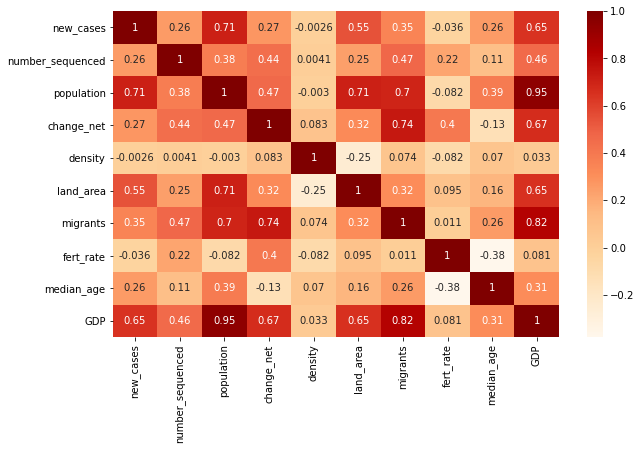

In [33]:
## Co-relation matrix
fig,ax = plt.subplots(figsize = (10,6))
sns.heatmap(df_final[['new_cases','number_sequenced','population','yearly_change','change_net',
                'density','land_area','migrants','fert_rate','median_age','urban_pop_pct','GDP']].corr(),annot=True, cmap="OrRd")

## TO REDO
PCA plotting

###   Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales
###    For the transformation of the data onto unit scale: mean=0 and variance=1

In [13]:
########TO DO########
#Here trying PCA all point, then try first and last day see if any changes 

In [14]:
features = ['new_cases','sum_newcases', 'sum_number_sequenced','sum_sequenced_pct', 'pct_sequenced_week']
x = df_sum.loc[:, features].values

In [15]:
y = df_sum.loc[:,['country']].values

In [16]:
df_sum.country.unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden'], dtype=object)

In [17]:
x = StandardScaler().fit_transform(x)

In [18]:
pd.DataFrame(data = x, columns = features).head()

,new_cases,sum_newcases,sum_number_sequenced,sum_sequenced_pct,pct_sequenced_week
0,-0.465866,-0.636151,-0.467634,-0.362840,-0.432305
1,-0.413340,-0.628579,-0.466426,-0.353465,-0.416642
2,-0.360910,-0.618737,-0.464360,-0.347775,-0.410183
3,-0.185153,-0.601282,-0.462447,-0.350245,-0.423082
4,0.090054,-0.571907,-0.459878,-0.352831,-0.425942


In [19]:
#Compute 5 PC, one for each variables I wanna try
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2','PC3','PC4','PC5'])
finalDf = pd.concat([principalDf, df_sum[['country']]], axis = 1)


### Verify which PC describes more variation

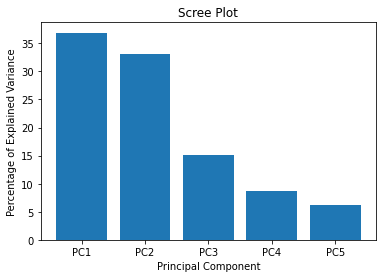

In [20]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

### Plots the 2 best PCs

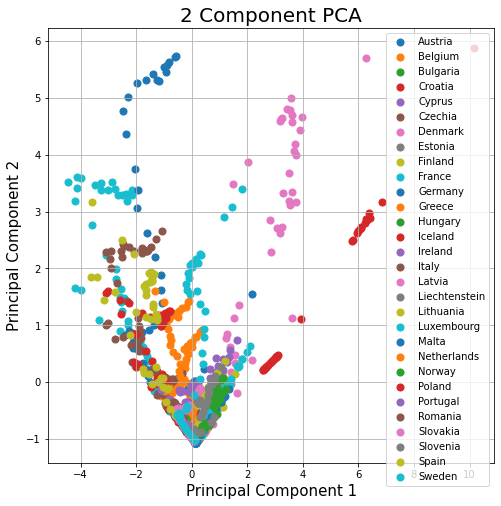

In [21]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = df_sum.country.unique()
NUM_COLORS = len(targets)

for target in targets:
    indicesToKeep = finalDf['country'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , s = 50)
ax.legend(targets)
ax.grid()

In [22]:
#TRY CHANGE COLOR FOR EACH COUNTRY PCA